>[Practical session Artificial Intelligence: Neural Networks](#scrollTo=PP0TTjo2IHcx)

>>[global settings](#scrollTo=wVUwqOFb2vPA)

>>[Usefull packages](#scrollTo=NelzDOpCgtJi)

>>>[Tensorflow and Keras](#scrollTo=KSrwJX4S0Ii3)

>>[Downloading database](#scrollTo=swisGM3dhew1)

>[Predefined methods](#scrollTo=FjlJZR05buO0)

>>[for generating database](#scrollTo=tZ6NSGiIb7B9)

>[Questions:](#scrollTo=9QPHVxlFDU9A)

>>[Database](#scrollTo=jjgUQifPbfzP)

>[Training](#scrollTo=Qyh-k6lhow8d)

>>[Building a neural network](#scrollTo=_FLKD5pdofZ6)

>>[Apples or not apples](#scrollTo=k-zqmB3EpFj4)

>>>[Saving and downloading model.](#scrollTo=flNrtOxp1VJF)

>>>[Learning rate](#scrollTo=eE2IqCqz3lGL)

>>[Fruit classifcation](#scrollTo=E8pTIAmKL29f)

>[Testing on own data](#scrollTo=KWq2N5EoRuTu)



#Practical session Artificial Intelligence: Neural Networks

Assistants: Laurens Meeus, Nina Žižakić

Professor: Aleksandra Pižurica

## global settings

For faster processing, make sure to set in *Runtime > Change runtime type*, *hardware accelerator* to *GPU*


##Usefull packages

### Tensorflow and Keras

In [0]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

%load_ext tensorboard

TensorFlow 2.x selected.


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print('Tensorflow version:')
!python3 -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15393291244504997331
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18172046907883975486
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14064823139072486833
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2467989805502470748
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Tensorflow version:
2.0.0


In [0]:
import datetime, os

import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, InputLayer
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
precision, recall = Precision(), Recall()

## Downloading database

Follow the instructions

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
googledrive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
id = '1FgVferCcjpps8fCr6-UKjKcJF3PmJikP'

download = googledrive.CreateFile({'id': id})
download.GetContentFile('2019_fruits_dataset.zip')
!unzip '2019_fruits_dataset.zip'

Archive:  2019_fruits_dataset.zip
replace 2019_fruits_dataset/1training/Apple Braeburn/0_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Predefined methods

## for generating database

In [0]:
class_names = ['apple', 'banana', 'cherry', 'grape', 'onion', 'peach', 'pear', 'pepper', 'plum', 'potato', 'tomato']

In [0]:
# rescale images to range [0; 1]
def im_preprocess(im):

    if im.max() > 1.:
        # to float instead of uint8
        im = np.divide(im, 255., dtype=np.float16)

    assert im.max() <= 1.

    return im

 
def get_data(dataset, factor_downsample = 1):
    """
    :param factor_downsample: skips images to reduce dataset size
    """

    assert dataset in ['training', 'validation', 'testing']

    print(f'Loading {dataset}-dataset')

    if dataset == 'training':
        home_folder = '2019_fruits_dataset/1training'
    elif dataset == 'validation':
        home_folder = '2019_fruits_dataset/2validation'
    else:
        home_folder = '2019_fruits_dataset/3test'

    x = []
    y = []

    folder_list = sorted(os.listdir(home_folder))

    for folder in folder_list:
        folder_lower = folder.lower()

        if 'apple' == folder_lower[:5]:            
            y_index = class_names.index('apple')
        
        elif 'banana' in folder_lower:
            y_index = class_names.index('banana')
            
        elif 'cherry' in folder_lower[:6]:
            y_index = class_names.index('cherry')
            
        elif 'grape ' in folder_lower:
            y_index = class_names.index('grape')
            
        elif 'onion' in folder_lower:
            y_index = class_names.index('onion')
            
        elif 'peach' in folder_lower:
            y_index = class_names.index('peach')
            
        elif 'pear' in folder_lower:
            y_index = class_names.index('pear')

        elif 'pepper' in folder_lower:
            y_index = class_names.index('pepper')
            
        elif 'plum' in folder_lower:
            y_index = class_names.index('plum')
            
        elif 'potato' in folder_lower:
            y_index = class_names.index('potato')
            
        elif 'tomato' in folder_lower:
            y_index = class_names.index('tomato')
        else:
            # Not included in assignment
            raise ValueError(f'Unknown class in {folder_lower}')
            continue

        folder_path = os.path.join(home_folder, folder)
        file_list = sorted(os.listdir(folder_path))
        for im_file in file_list:
            
            name, _ = os.path.splitext(im_file)
            index_file = int(name.split('_')[-2])   # Second to last! Last element is width image (=100)
            if (index_file % factor_downsample) != 0:
                continue
        
            im_path = os.path.join(folder_path, im_file)

            im = plt.imread(im_path)
            im = im_preprocess(im)

            x.append(im)
            y.append(y_index)

    print(f'Finished {dataset}-dataset')
    return x, y

# Questions:

## Database

In [0]:
print(class_names)

print('Training data')
x_train, y_train = get_data('training', factor_downsample = 1)
x_valid, y_valid = get_data('validation', factor_downsample = 1)
x_test, y_test = get_data('testing', factor_downsample = 1)

['apple', 'banana', 'cherry', 'grape', 'onion', 'peach', 'pear', 'pepper', 'plum', 'potato', 'tomato']
Training data
Loading training-dataset
Finished training-dataset
Loading validation-dataset
Finished validation-dataset
Loading testing-dataset
Finished testing-dataset


In [0]:
print(len(x_train), len(y_train))
print(len(x_valid), len(y_valid))
print(len(x_test), len(y_test))

20685 20685
10317 10317
9950 9950


In [0]:
print(len(x_train[0]))
print(len(x_train[0][0]))
print(len(x_train[0][0][0]))

100
100
3


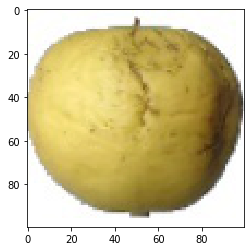

In [0]:
random_index = np.random.randint(0, len(x_train))
plt.imshow(np.array(x_train[random_index],dtype=float))
plt.show()

In [0]:
print(class_names)
print(len(class_names))
print(y_train[random_index], class_names[y_train[random_index]])

['apple', 'banana', 'cherry', 'grape', 'onion', 'peach', 'pear', 'pepper', 'plum', 'potato', 'tomato']
11
0 apple


In [0]:
_, counts = np.unique(y_train, return_counts=True)
print(counts)
print(sum(counts))

_, counts = np.unique(y_valid, return_counts=True)
print(counts)
print(sum(counts))

_, counts = np.unique(y_test, return_counts=True)
print(counts)
print(sum(counts))

[4330  959 2296 2296  900 1148 2426 1184 1212 1206 2728]
20685
[2164  478 1148 1148  450  574 1212  592  602  603 1346]
10317
[2060  477 1148 1121  429  574 1212  592  550  595 1192]
9950


# Training

In [0]:
x_train = np.stack(x_train, axis=0).astype(np.float16)
x_valid = np.stack(x_valid, axis=0).astype(np.float16)
x_test = np.stack(x_test, axis=0).astype(np.float16)

y_train = np.stack(y_train, axis=0).astype(np.int16)
y_valid = np.stack(y_valid, axis=0).astype(np.int16)
y_test = np.stack(y_test, axis=0).astype(np.int16)

def y_to_apple(y):
    i_apple = class_names.index('apple')
    y_apple = np.equal(y, i_apple, dtype=np.int16)
    return y_apple

y_train_apple = y_to_apple(y_train)
y_valid_apple = y_to_apple(y_valid)
y_test_apple = y_to_apple(y_test)

y_train_fruit = to_categorical(y_train)
y_valid_fruit = to_categorical(y_valid)
y_test_fruit = to_categorical(y_test)

## Building a neural network

In [0]:
pract_folder = 'drive/My Drive/AI_pract3_nn2019'
logs_folder = os.path.join(pract_folder, 'logs')
weights_folder = os.path.join(pract_folder, 'weights')
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)


In [0]:
def get_model_base_simple(k = 4):  
    model = Sequential()
    model.epoch = 0     # to save amount of epochs trained

    model.add(InputLayer((100, 100, 3)))
    model.add(AveragePooling2D(pool_size=(2, 2))) # downsampling
    model.add(Conv2D(k, (3, 3), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(k, (3, 3), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(7, (4, 4), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(k, activation='elu'))

    return model


def get_model_apple_simple(lr, loss='mse'):
  
    model = get_model_base_simple()

    # single class classification
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=loss,
                optimizer=SGD(lr),
                metrics=['accuracy', precision, recall])

    return model


def get_model_fruit_simple(lr):
    model = get_model_base_simple()
  
    ### To implement yourself
    model.add(None)
    model.compile(loss=None,
                optimizer=sgd(lr),
                metrics=['accuracy'])

    return model


## Apples or not apples

In [0]:
model_apple = get_model_apple_simple(lr=1e-2)

### uncomment if you already have a trained network
# model_apple = keras.models.load_model(os.path.join(weights_folder, '<apple.hdf5>'))

model_apple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 4)         112       
_________________________________________________________________
average_pooling2d_1 (Average (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 4)         148       
_________________________________________________________________
average_pooling2d_2 (Average (None, 11, 11, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 7)           455       
_________________________________________________________________
average_pooling2d_3 (Average (None, 4, 4, 7)           0

In [0]:
def train_model(epochs = 20):
    t_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = os.path.join(logs_folder, t_now)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, write_graph=False)

    weightdir = os.path.join(weights_folder, f"{t_now}_" + "{epoch}.hdf5")
    checkpoint = tf.keras.callbacks.ModelCheckpoint(weightdir)

    model_apple.fit(x_train, y_train_apple, validation_data=(x_valid, y_valid_apple),
                    initial_epoch = model_apple.epoch,
                    batch_size=64, epochs=model_apple.epoch + epochs,
                    verbose=1,
                    callbacks=[tensorboard_callback, checkpoint]
                    )
    model_apple.epoch += epochs

train_model()
print(model_apple.epoch)

Train on 20685 samples, validate on 10317 samples
Epoch 1/20
20685/20685 [==============================] - 4s 179us/sample - loss: 0.1759 - accuracy: 0.7879 - precision_2: 0.0328 - recall_2: 4.6189e-04 - val_loss: 0.1669 - val_accuracy: 0.7902 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
20685/20685 [==============================] - 3s 131us/sample - loss: 0.1661 - accuracy: 0.7907 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.7902 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
20685/20685 [==============================] - 3s 130us/sample - loss: 0.1649 - accuracy: 0.7907 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1643 - val_accuracy: 0.7902 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/20
20685/20685 [==============================] - 3s 131us/sample - loss: 0.1636 - accuracy: 0.7907 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1630 - val_accu

This will give you live feedback of the training.

When tensorboard isn't updating properly, use ``notebook.list()`` to find the pid and use ``!kill <pid>`` to rerun tensorboard

In [0]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


In [0]:
!kill 875
%tensorboard --logdir 'drive/My Drive/AI_pract3_nn2019'

/bin/bash: line 0: kill: (875) - No such process


Reusing TensorBoard on port 6006 (pid 2718), started 2:57:06 ago. (Use '!kill 2718' to kill it.)

In [0]:
y_test_pred = model_apple.predict(x_test)

[0.9457]
0


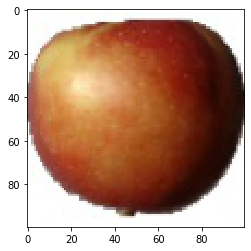

In [0]:
print(y_test_pred[0])
print(y_test[0])
plt.imshow(np.array(x_test[0],dtype=float))
plt.show()

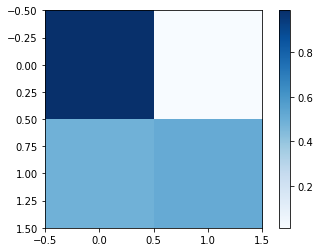

In [0]:
import sklearn
from sklearn.metrics import confusion_matrix
cm = sklearn.metrics.confusion_matrix(y_test_apple, np.rint(y_test_pred))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

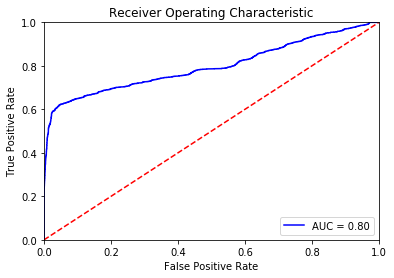

In [0]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_apple, y_test_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



###Saving and downloading model.

Alternatively you can download it manually through: *View -> Table of contents -> Files -> Right click* **.h5-> Download*

In [0]:
path = os.path.join(weights_folder, 'apple.h5')
model_apple.save(path)

### Learning rate

In [0]:
### Settings: going from lr = 1e-5 till 1e+5 
n_lr = 50
lr_start = 1e-5
lr_end = 1e+5

### Initialisation

# new model, new inititialisation of weights.
model_apple = get_model_apple_simple(lr=0)

lst_epochs = []
lst_train_cost = []
lst_valid_cost = []

lst_lr = [lr_start*(lr_end/lr_start)**(i/n_lr) for i in range(n_lr+1)]

for i, lr in enumerate(lst_lr):
    print('EPOCH', i, '/', n_lr)  
    print('lr = ', lr)
       
    model_apple.compile(loss='mse',
                optimizer=SGD(lr), # setting the learning rate
                metrics=['accuracy'])
    
    hist = model_apple.fit(x_train, y_train_apple, validation_data=(x_valid, y_valid_apple),
              batch_size=32, 
              initial_epoch = i,
              epochs=i+1,
              verbose=1)
    model_apple.epoch += 1

    lst_epochs.append(i)
    lst_train_cost.append(hist.history['loss'])
    lst_valid_cost.append(hist.history['val_loss'])


EPOCH 0 / 50
lr =  1e-05
Train on 20685 samples, validate on 10317 samples
20685/20685 [==============================] - 4s 200us/sample - loss: 0.2632 - accuracy: 0.3319 - val_loss: 0.2627 - val_accuracy: 0.3304
EPOCH 1 / 50
lr =  1.5848931924611138e-05
Train on 20685 samples, validate on 10317 samples
Epoch 2/2
20685/20685 [==============================] - 4s 202us/sample - loss: 0.2592 - accuracy: 0.3883 - val_loss: 0.2580 - val_accuracy: 0.4016
EPOCH 2 / 50
lr =  2.5118864315095805e-05
Train on 20685 samples, validate on 10317 samples
Epoch 3/3
20685/20685 [==============================] - 4s 202us/sample - loss: 0.2534 - accuracy: 0.4854 - val_loss: 0.2513 - val_accuracy: 0.5025
EPOCH 3 / 50
lr =  3.981071705534973e-05
Train on 20685 samples, validate on 10317 samples
Epoch 4/4
20685/20685 [==============================] - 4s 206us/sample - loss: 0.2454 - accuracy: 0.6096 - val_loss: 0.2423 - val_accuracy: 0.6373
EPOCH 4 / 50
lr =  6.309573444801933e-05
Train on 20685 samples,

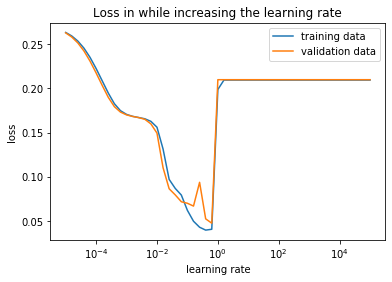

In [0]:
plt.figure()
plt.plot(lst_lr, lst_train_cost, label='training data')
plt.plot(lst_lr, lst_valid_cost, label='validation data')

plt.xlabel('learning rate')
plt.ylabel('loss')
plt.xscale('log')
plt.title('Loss in while increasing the learning rate')
plt.legend()

In [0]:
from sklearn.metrics import accuracy_score
k_values = np.array(range(10))+3
loss_types = ['mse', 'binary_crossentropy']
#k_val = 7
#loss_type = 'mse'

for k_val in k_values:
  for loss_type in loss_types:
    model_apple = get_model_apple_simple(lr=0.5, loss=loss_type, k=k_val)
    model_apple.fit(x_train, y_train_apple, validation_data=(x_valid, y_valid_apple),
                      initial_epoch = 0,
                      batch_size=64, epochs=10,
                      verbose=1)
    y_pred = model_apple.predict(x_test)
    y_pred = np.where(y_pred > 0.5, 1,0)
    acc = accuracy_score(y_test_apple, y_pred)
    print(f'Accuracy for {k_val} feature maps with {loss_type} loss: {acc}')
    #model_apple.summary()

#path = os.path.join(weights_folder, 'apple.hdf5')
#model_apple.save(path)

In [0]:
model = get_model_apple_simple(0.5, loss='mse')
print(model.summary())
hist = model.fit(x_train, y_train_apple, validation_data=(x_valid, y_valid_apple), batch_size=64, epochs=10, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_8 (Average (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 4)         112       
_________________________________________________________________
average_pooling2d_9 (Average (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 4)         148       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 11, 11, 4)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 7)           455       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 4, 4, 7)          

In [0]:
model.evaluate(x_test, y_test_apple)

9950/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0711920586647196, 0.9258292, 0.92535394, 0.69805825]

In [0]:
model.save_weights(os.path.join(weights_folder, "APPLE_ONLY.hdf5"))

## Fruit classifcation

In [0]:
# to implement
def get_model_fruit_simple():
  model = get_model_base_simple()

  # single class classification
  model.add(Dense(11, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

model_fruit = get_model_fruit_simple()

model_fruit.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_96 (Averag (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 48, 48, 4)         112       
_________________________________________________________________
average_pooling2d_97 (Averag (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 22, 22, 4)         148       
_________________________________________________________________
average_pooling2d_98 (Averag (None, 11, 11, 4)         0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 8, 8, 7)           455       
_________________________________________________________________
average_pooling2d_99 (Averag (None, 4, 4, 7)         

In [0]:
# train
t_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(logs_folder, t_now)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, write_graph=False)

weightdir = os.path.join(weights_folder, f"{t_now}_" + "{epoch}.hdf5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(weightdir)

model_fruit.fit(x_train, y_train_fruit, validation_data=(x_valid, y_valid_fruit),
                batch_size=32,
                epochs=100,
                verbose=1,
                callbacks=[tensorboard_callback, checkpoint]
                )

Train on 20685 samples, validate on 10317 samples
Epoch 1/100
   32/20685 [..............................] - ETA: 1:59

ValueError: ignored

In [0]:
model_fruit.load_weights(os.path.join(weights_folder, "20191130-134817_100.hdf5"))
model_fruit.evaluate(x_test, y_test_fruit)

9950/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.281634644661615, 0.7790955]

In [0]:
y_test_pred = model_fruit.predict(x_test)

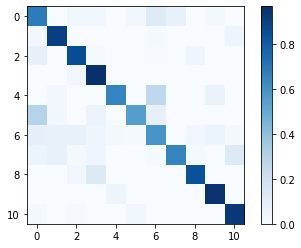

In [0]:
cm = sklearn.metrics.confusion_matrix(y_test, np.argmax(y_test_pred, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

# Testing on own data

In [0]:
from PIL import Image
import requests
from io import BytesIO
import cv2

[[0.9954867]]


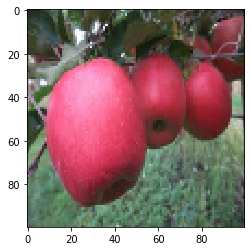

In [0]:
# url = 'https://images-na.ssl-images-amazon.com/images/I/319J7YpfyNL.jpg'
# url = 'http://dizabo.ae/images/thumbs/0000026_red-apple_510.jpeg'
# url = 'https://i5.walmartimages.ca/images/Large/580/6_r/875806_R.jpg'
# url = 'https://d1ubpsppdzqxsq.cloudfront.net/image/original/1d/65/e3/1d65e30bbad30aa96e6048e0d6f8f9ae39164588.jpg'
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ-QUYF7RngJiIclIuCRzL9y5DR_QyibNFr1h74pIOUfNi1hCk&s'

def open_image(path):
    response = requests.get(path)
    img = np.array(Image.open(BytesIO(response.content)))

    resize = cv2.resize(img, (100, 100))

    plt.figure()
    plt.imshow(resize)
    plt.plot()

    single_x = np.stack([resize], axis=0)
    im_resize = im_preprocess(single_x)

    # TODO preprocessing 
    ...

    return im_resize

single_x = open_image(url) # '<your_fruit.jpg>'

#model_apple = load_model(weights_folder + '/<model_appled>.hdf5')
#model_fruit = load_model(weights_folder + '/<model_fruit>.hdf5')

pred_apple = model.predict(single_x)
#pred = model_fruit.predict(single_x)
#pred_fruit = class_names[np.argmax(pred)]

print(pred_apple)
#print(pred_fruit)
#print(np.amax(pred))